Dimensionality Reduction
Dimensionality reduction methods seek to take a large set of variables and return a smaller set of components that still contain most of the information in the original dataset.
This implies an inherent tradeoff between information loss and improved interpretability: all dimensionality reduction methods discard some information, but they also play an important role in helping us make sense of a giant matrix of values.
One example of dimensionality reduction in PCA  was covered in the previous notebook

Let's look at two other common approaches to dimensionality reduction: tSNE and UMAP

tSNE
tSNE (t-Distributed Stochastic Neighbor Embedding) combines dimensionality reduction (e.g. PCA) with random walks on the nearest-neighbour network to map high dimensional data (i.e. our 18,585 dimensional expression matrix) to a 2-dimensional space.
In contrast with PCA, tSNE can capture nonlinear structure in the data, and tries to preserve the local distances between cells. - - Due to the non-linear and stochastic nature of the algorithm, tSNE is more difficult to intuitively interpret: while tSNE faithfully represents local relationships, it doesn't always capture the relatioships between more distant cells correctly.
The method when run multiple times on the same dataset will result in different plots because tSNE is a stochastic algorithm.
To ensure reproducibility, we fix the "seed" of the random-number generator in the code below so that we always get the same plot.

In [1]:
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from matplotlib import pyplot as plt

#matplotlib inline incantation
%matplotlib inline

In [2]:
adata = sc.read ('brain_normalized.h5ad')

In [4]:
adata.var.head()


,ERCC,n_cells,n_counts,mean,std
0610005C13Rik,False,28,402.0,0.008258,0.097374
0610007C21Rik,False,2391,697885.0,1.282997,0.836781
0610007L01Rik,False,960,122226.0,0.432518,0.714138
0610007N19Rik,False,270,22099.0,0.117806,0.413909
0610007P08Rik,False,582,55534.0,0.247591,0.566559


In [5]:

adata.obs.head()


,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode,n_genes,n_counts
cell,,,,,,,
A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290,3359,390075.0
A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728,1718,776436.0
A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560,3910,1616086.0
A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564,4352,360004.0
A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923,2248,290282.0


In [6]:

adata.X.shape

(3304, 18661)

C:\Users\samen\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


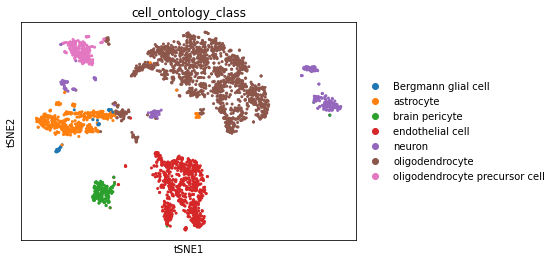

In [7]:
sc.tl.tsne(adata, perplexity=30, learning_rate=1000, random_state=0)
#adds X_tsne in obsm

sc.pl.tsne(adata, color='cell_ontology_class')
#PLots using X_tsne using tSNE coordinates of the data


In [8]:
adata 

AnnData object with n_obs × n_vars = 3304 × 18661
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes', 'n_counts'
    var: 'ERCC', 'n_cells', 'n_counts', 'mean', 'std'
    uns: 'log1p', 'mouse.id_colors', 'pca', 'plate.barcode_colors', 'tsne', 'cell_ontology_class_colors'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

from the results above, it can seen that adata.obsm is updated with X_tsne which is tSNE coordinates of data.

Here, we see that tSNE generally does a good job of grouping similar cell types together (much better than PCA alone), but there are still some neurons that are not grouped together.

UMAP
UMAP (Uniform Approximation and Projection) is another nonlinear dimensionality reduction method.
Like tSNE, UMAP is nondeterministic and requires that we fix the random seed to ensure reproducibility.
While tSNE optimizes for local structure, UMAP tries to balance the preservation of local and global structure. For this reason, we prefer UMAP over tSNE for exploratory analysis and general visualization.

In [9]:
sc.pp.neighbors(adata)
#UMAP is based on the neighbor graph; this will be computed first
#secondly, a graph of neighborhood observations will be computed
#depending on copy, updates or returns adata with the following: connectivities and distances
sc.tl.umap(adata, min_dist=0.5, spread = 1.0, random_state=1, n_components=2)
#adds X_umap in obsm

In [10]:
adata

AnnData object with n_obs × n_vars = 3304 × 18661
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes', 'n_counts'
    var: 'ERCC', 'n_cells', 'n_counts', 'mean', 'std'
    uns: 'log1p', 'mouse.id_colors', 'pca', 'plate.barcode_colors', 'tsne', 'cell_ontology_class_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

From the results above, we note that UMAP does a better job of grouping cells together and achieving clean separation between cell types.

In [11]:
adata.X.shape 

(3304, 18661)

In [12]:
adata.write('brain_embeddings.h5ad')

CLUSTERING 
Grouping cells based on the similarity of their expression profiles allows us to identify cell types and states, as well as infer differences between groups. This is done either via clustering or community detection.

Some of the most popular approaches are hierarchical clustering and k-means clustering. These methods compute a distance metric between cells (often based on a low-dimensional representation, such as PCA, tSNE or UMAP), and then iteratively group cells together based on these distances.

Community detection methods (also referred to as 'graph-based clustering') partition the neighbor graph. The neighbor graph treats each cell as a node, with edges connecting each node to its k nearest neighbors (based on similar distance metrics described above). The graph is then partitioned into modules based on these connectivities. These methods are typically faster than other clustering methods with similar effectiveness.

All clustering or community detection methods have is a resolution parameter that controls how fine- or coarse-grained the inferred clusters are. This parameter can have major effects on your results.

Here, we'll explore k-means clustering and the graph-based louvain clustering method.

In [13]:
adata = sc.read('brain_embeddings.h5ad')

In [14]:
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from matplotlib import pyplot as pyplot

%matplotlib inline

k-means - Applied on UMAP
In k-means clustering, the goal is to partition N cells into k different clusters. This is done in an iterative manner, cluster centers are assigned and each cell is assigned to its nearest cluster:
Let's try this out on the umap representation of our dataset. Scanpy doesn't include a method for k-means clustering, so we'll extract the umap coordinates that we calculated earlier and use scikit-learn for this task instead.

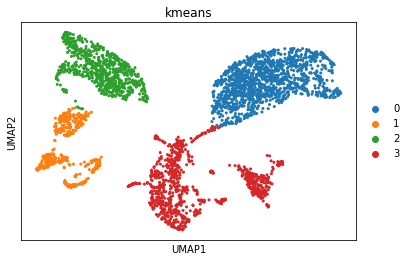

In [15]:
#Extract the UMAP coordinates for each cell
umap_coordinates = adata.obsm['X_umap']

#fix the random state for reproducibility
kmeans = KMeans(n_clusters=4, random_state = 0).fit(umap_coordinates)

#Retrieve the labels and add them as a metadata column in my AnnDAta object
adata.obs['kmeans'] = kmeans.labels_

adata.obs['kmeans'] = adata.obs['kmeans'].astype(str)

#plot the results, plotting the umap with the color as the cluster label
sc.pl.umap(adata, color = 'kmeans')

In [16]:
print(kmeans.labels_)
adata.obs.head()

[3 3 0 ... 2 0 3]


,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode,n_genes,n_counts,kmeans
cell,,,,,,,,
A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290,3359,390075.0,3
A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728,1718,776436.0,3
A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560,3910,1616086.0,0
A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564,4352,360004.0,2
A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923,2248,290282.0,3


Evaluating clustering
Intuitively, we can see from the plot that our value of k (the number of clusters) is probably too low.
This dataset has "ground truth" cell type labels available (This might not be with every case) We can use these to assess our cluster labels a bit more rigorously using the adjusted Rand index.
This index is a measure between (0, 1) which indicates the similarity between two sets of categorical labels (e.g., our cell type labels and cluster labels). A value of 1 means the two clusterings are identical, and 0 means the level of similarity expected by random chance.

In [17]:
adata.obs['cell_ontology_class'].unique()

['astrocyte', 'oligodendrocyte', 'endothelial cell', 'neuron', 'oligodendrocyte precursor cell', 'Bergmann glial cell', 'brain pericyte']
Categories (7, object): ['Bergmann glial cell', 'astrocyte', 'brain pericyte', 'endothelial cell', 'neuron', 'oligodendrocyte', 'oligodendrocyte precursor cell']

In [18]:
rand_index = adjusted_rand_score(labels_true = adata.obs['cell_ontology_class'], labels_pred= adata.obs['kmeans'])

print('The Rand Index is', round(rand_index, 2))


The Rand Index is 0.78


The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.
The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation).
Higher the score, better the clustering

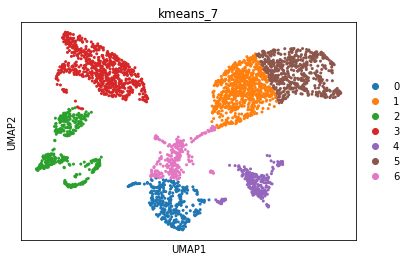

In [20]:
# rerunning k-means clustering with several different values of k.

#Lets try with K=7 as the total cell types is also 7

#Saving these results with column_name = kmeans_7

#extract the UMAP coordinates for each cell
umap_coordinates = adata.obsm['X_umap']

#Fix the random state for repreoducibility
kmeans = KMeans(n_clusters=7, random_state=0).fit(umap_coordinates)


#retrieve the labels and add them as a metadata column in our Ann Data object
adata.obs['kmeans_7'] = kmeans.labels_
adata.obs['kmeans_7'] = adata.obs['kmeans_7'].astype(str)


#Plotting the results; plotting umap with the color as the cluster label
sc.pl.umap(adata, color = 'kmeans_7')

In [21]:
rand_index = adjusted_rand_score(labels_true =adata.obs['cell_ontology_class'], labels_pred = adata.obs['kmeans_7'])

print('The rand index is', round(rand_index, 2))


The rand index is 0.6


Graph-based methods
Graph-based methods attempt to partition a pre-computed neighhbor graph into modules (i.e., groups / clusters of cells) based on their connectivity.
Currently, the most widely used graph-based methods for single cell data are variants of the louvain algorithm. 

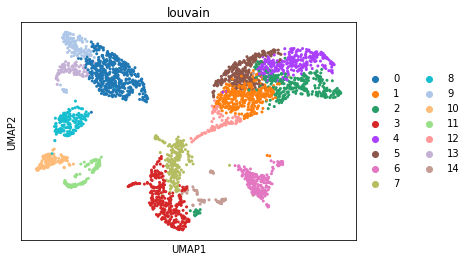

In [23]:
from scanpy.tl import louvain
louvain(adata) #cluster cells into subgroups #adata.obs['louvain']

sc.pl.umap(adata, color = 'louvain')

In [24]:
adata.obs.head()
#note that louvain column is added

,cell_ontology_class,subtissue,mouse.sex,mouse.id,plate.barcode,n_genes,n_counts,kmeans,kmeans_7,louvain
cell,,,,,,,,,,
A1.B003290.3_38_F.1.1,astrocyte,Striatum,F,3_38_F,B003290,3359,390075.0,3,0,3
A1.B003728.3_56_F.1.1,astrocyte,Striatum,F,3_56_F,B003728,1718,776436.0,3,6,7
A1.MAA000560.3_10_M.1.1,oligodendrocyte,Cortex,M,3_10_M,MAA000560,3910,1616086.0,0,1,1
A1.MAA000564.3_10_M.1.1,endothelial cell,Striatum,M,3_10_M,MAA000564,4352,360004.0,2,3,9
A1.MAA000923.3_9_M.1.1,astrocyte,Hippocampus,M,3_9_M,MAA000923,2248,290282.0,3,0,3


In [25]:
adata

AnnData object with n_obs × n_vars = 3304 × 18661
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes', 'n_counts', 'kmeans', 'kmeans_7', 'louvain'
    var: 'ERCC', 'n_cells', 'n_counts', 'mean', 'std'
    uns: 'cell_ontology_class_colors', 'log1p', 'mouse.id_colors', 'neighbors', 'pca', 'plate.barcode_colors', 'tsne', 'umap', 'kmeans_colors', 'kmeans_7_colors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [26]:
rand_index = adjusted_rand_score(adata.obs['cell_ontology_class'], adata.obs['louvain'])
print('The rand index is ', round(rand_index, 2))


The rand index is  0.36


The low rand index with the default resolution parameter is quite low (0.34), but this increases to 0.9 when we set resolution=0.1.
Higher resolution means finding more and smaller clusters

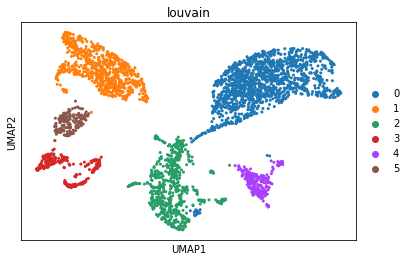

The rand index is  0.87


In [27]:
louvain(adata, resolution=0.1) #cluster cells into subgroups #adata.obs['louvain']

sc.pl.umap(adata, color = 'louvain')

rand_index = adjusted_rand_score(adata.obs['cell_ontology_class'], adata.obs['louvain'])
print('The rand index is ', round(rand_index, 2))

Sometimes, we may want to look at clusters within a given tissue or cell type designation. This can surface interesting heterogeneity between subpopulations, although it can also make our results more noisy.


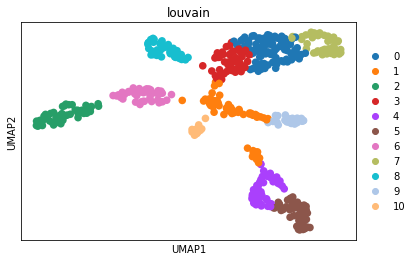

In [28]:
#Looking into the cells having Cerebellum subtissue.
cerebellum = adata[adata.obs['subtissue']== 'Cerebellum']
sc.pp.neighbors(cerebellum)
sc.tl.umap(cerebellum)

sc.tl.louvain(cerebellum)
sc.pl.umap(cerebellum, color = 'louvain')


In [29]:
cerebellum

AnnData object with n_obs × n_vars = 518 × 18661
    obs: 'cell_ontology_class', 'subtissue', 'mouse.sex', 'mouse.id', 'plate.barcode', 'n_genes', 'n_counts', 'kmeans', 'kmeans_7', 'louvain'
    var: 'ERCC', 'n_cells', 'n_counts', 'mean', 'std'
    uns: 'cell_ontology_class_colors', 'log1p', 'mouse.id_colors', 'neighbors', 'pca', 'plate.barcode_colors', 'tsne', 'umap', 'kmeans_colors', 'kmeans_7_colors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [30]:
#Saving clustered adata
sc.tl.louvain(adata, resolution = 0.1)
adata.write('brain_clusters.h5ad')


Summary

Dimensionality Reduction
tSNE
UMAP


Clustering
k-Means on tSNE
Evaluating the k-means clustering
Playing with No of cluster in k-means
Graph Based Clustering Method - Louvain
Tuning thr resolution parameter
Seeing clusters in cells of a perticular sybtissue
Saving the adata